# Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Loading Datasets

In [ ]:
train_data = pd.read_csv('/content/train_data_v3.csv')
test_data = pd.read_csv('/content/test_data_v3.csv')
validate_data = pd.read_csv('/content/validate_data_v3.csv')

train_data.info()
test_data.info()
validate_data.info()

train_data.head()
test_data.head()
validate_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 70 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   End_Time                                          8000 non-null   int64  
 1   Distance(mi)                                      8000 non-null   float64
 2   Temperature(F)                                    8000 non-null   float64
 3   Humidity(%)                                       8000 non-null   float64
 4   Pressure(in)                                      8000 non-null   float64
 5   Visibility(mi)                                    8000 non-null   float64
 6   Wind_Speed(mph)                                   8000 non-null   float64
 7   Precipitation(in)                                 8000 non-null   float64
 8   Amenity                                           8000 non-null   int64  
 9   Bump               

,End_Time,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,...,Wind_Direction_WSW,Wind_Direction_West,Weather_Day_of_Week_Friday,Weather_Day_of_Week_Monday,Weather_Day_of_Week_Saturday,Weather_Day_of_Week_Sunday,Weather_Day_of_Week_Thursday,Weather_Day_of_Week_Tuesday,Weather_Day_of_Week_Wednesday,Severity
0,1376,0.013,46.0,83.0,29.02,10.0,0.0,0.00,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1152,0.086,79.0,62.0,30.05,10.0,9.0,0.00,0,0,...,0,0,0,1,0,0,0,0,0,2
2,928,0.700,60.0,55.0,29.80,10.0,13.0,0.00,0,0,...,0,0,0,0,0,0,0,1,0,3
3,327,0.000,18.0,84.0,31.08,1.2,10.4,0.01,0,0,...,0,0,0,0,0,0,0,0,1,3
4,656,0.386,72.0,69.0,25.02,10.0,0.0,0.00,0,0,...,0,0,0,0,1,0,0,0,0,2


# Building Model

## Separate Target and Features

In [ ]:
X_train = train_data.drop(columns=['Severity'])
y_train = train_data['Severity']
X_test = test_data.drop(columns=['Severity'])
y_test = test_data['Severity']
X_validate = validate_data.drop(columns=['Severity'])
y_validate = validate_data['Severity']

## Scale Data

In [ ]:
# Scale the data before feature selection and model training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

##Base Model: Linear SVM

In [ ]:
param_grid = {
    'C': [0.1, 1, 5, 10],  # Try different values of C
    'kernel': ['linear']  # Force it to only use linear kernel
}

In [ ]:
grid_search = GridSearchCV(
    SVC(),                # Base model
    param_grid,           # Hyperparameter grid
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Optimize for accuracy
    n_jobs=-1             # Use all cores
)

In [ ]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10], 'kernel': ['linear']},
             scoring='accuracy')

In [ ]:
# Evaluate the best model on the test set
best_linear_svm = grid_search.best_estimator_
y_validate_pred_balanced = best_linear_svm.predict(X_validate_scaled)
test_accuracy_balanced = accuracy_score(y_validate, y_validate_pred_balanced)
test_report_balanced = classification_report(y_validate, y_validate_pred_balanced)

# Print results
print("Best Linear SVM Model:", grid_search.best_params_)
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Best Linear SVM Model: {'C': 10, 'kernel': 'linear'}
Test Accuracy After Balancing: 0.341
Classification Report:
               precision    recall  f1-score   support

           1       0.05      0.79      0.10        14
           2       0.93      0.29      0.44       828
           3       0.28      0.60      0.38       124
           4       0.06      0.44      0.10        34

    accuracy                           0.34      1000
   macro avg       0.33      0.53      0.26      1000
weighted avg       0.81      0.34      0.42      1000



<Figure size 1000x800 with 0 Axes>

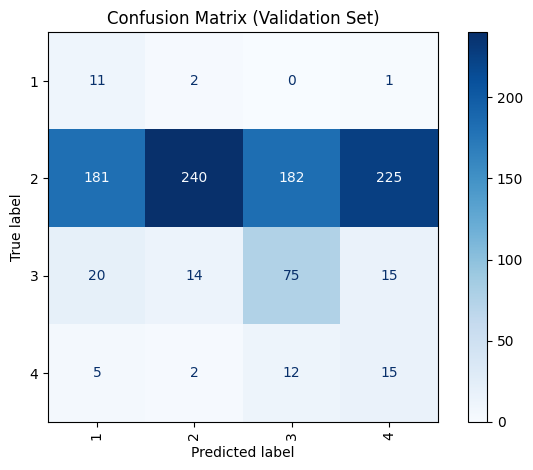

[[ 11   2   0   1]
 [181 240 182 225]
 [ 20  14  75  15]
 [  5   2  12  15]]
acc1 (Exact match accuracy): 0.3410
acc2 (One-off accuracy): 0.7470


In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_linear_svm, X_validate_scaled, y_validate,
                                      cmap='Blues',
                                      display_labels=best_linear_svm.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = best_linear_svm.predict(X_validate_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_validate, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")

##SVM 2nd Model (kernel=rbf)

In [ ]:
param_grid = {
    'svm__C': [0.1, 1, 5, 10],
    'svm__gamma': [0.01, 0.1, 1]
}

svm_rbf = Pipeline([
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True))
])

In [ ]:
grid_search = GridSearchCV(svm_rbf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('svm',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             param_grid={'svm__C': [0.1, 1, 5, 10],
                         'svm__gamma': [0.01, 0.1, 1]},
             scoring='accuracy')

In [ ]:
# Predict on validation set
best_rbf_model = grid_search.best_estimator_
y_validate_pred = best_rbf_model.predict(X_validate_scaled)

# Evaluate performance on validation set
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
validate_report = classification_report(y_validate, y_validate_pred)

# Print results on validation set
print("Best RBF SVM Model:", grid_search.best_params_)
print("Validation Accuracy ", validate_accuracy)
print("Classification Report (Validation Set):\n", validate_report)

# Evaluate the best model on the test set
y_test_pred_balanced = best_rbf_model.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Best RBF SVM Model: {'svm__C': 1, 'svm__gamma': 0.01}
Validation Accuracy  0.37
Classification Report (Validation Set):
               precision    recall  f1-score   support

           1       0.06      0.79      0.11        14
           2       0.94      0.32      0.48       828
           3       0.30      0.64      0.41       124
           4       0.05      0.35      0.08        34

    accuracy                           0.37      1000
   macro avg       0.33      0.52      0.27      1000
weighted avg       0.82      0.37      0.45      1000

Test Accuracy After Balancing: 0.359
Classification Report:
               precision    recall  f1-score   support

           1       0.03      0.83      0.05         6
           2       0.91      0.33      0.48       857
           3       0.25      0.54      0.34       119
           4       0.03      0.50      0.07        18

    accuracy                           0.36      1000
   macro avg       0.31      0.55      0.24      1000
wei

<Figure size 1000x800 with 0 Axes>

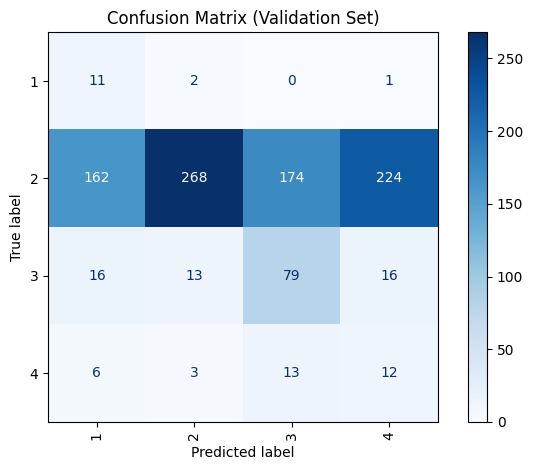

[[ 11   2   0   1]
 [162 268 174 224]
 [ 16  13  79  16]
 [  6   3  13  12]]
acc1 (Exact match accuracy): 0.3700
acc2 (One-off accuracy): 0.7500


In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_rbf_model, X_validate_scaled, y_validate,
                                      cmap='Blues',
                                      display_labels=best_rbf_model.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = best_rbf_model.predict(X_validate_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_validate, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")

## SVM 3rd Model (kernel = poly)

In [ ]:
svm_poly = Pipeline([
    ('svm', SVC(kernel='poly', class_weight='balanced', probability=True))
])

# Define the hyperparameter grid
param_grid = {
    'svm__C': [0.1, 1, 5],
    'svm__degree': [2, 3, 4],
    'svm__gamma': ['scale', 0.01, 0.1]
}

In [ ]:
grid_search_poly = GridSearchCV(svm_poly, param_grid, cv=5, scoring='accuracy')
grid_search_poly.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('svm',
                                        SVC(class_weight='balanced',
                                            kernel='poly',
                                            probability=True))]),
             param_grid={'svm__C': [0.1, 1, 5], 'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 0.01, 0.1]},
             scoring='accuracy')

In [ ]:
# Predict on validation set (for hyperparameter tuning)
best_poly_model = grid_search_poly.best_estimator_
y_validate_pred = best_poly_model.predict(X_validate_scaled)

# Evaluate performance on validation set
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
validate_report = classification_report(y_validate, y_validate_pred)

# Print results on validation set
print("Best Poly SVM Model:", grid_search_poly.best_params_)
print("Validation Accuracy ", validate_accuracy)
print("Classification Report (Validation Set):\n", validate_report)

# Evaluate the best model on the test set
y_test_pred_balanced = best_poly_model.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Best Poly SVM Model: {'svm__C': 5, 'svm__degree': 2, 'svm__gamma': 'scale'}
Validation Accuracy  0.378
Classification Report (Validation Set):
               precision    recall  f1-score   support

           1       0.06      0.79      0.12        14
           2       0.91      0.36      0.51       828
           3       0.23      0.48      0.31       124
           4       0.05      0.35      0.09        34

    accuracy                           0.38      1000
   macro avg       0.31      0.49      0.26      1000
weighted avg       0.78      0.38      0.47      1000

Test Accuracy After Balancing: 0.392
Classification Report:
               precision    recall  f1-score   support

           1       0.04      1.00      0.07         6
           2       0.93      0.38      0.54       857
           3       0.24      0.41      0.30       119
           4       0.03      0.50      0.06        18

    accuracy                           0.39      1000
   macro avg       0.31      0.57 

<Figure size 1000x800 with 0 Axes>

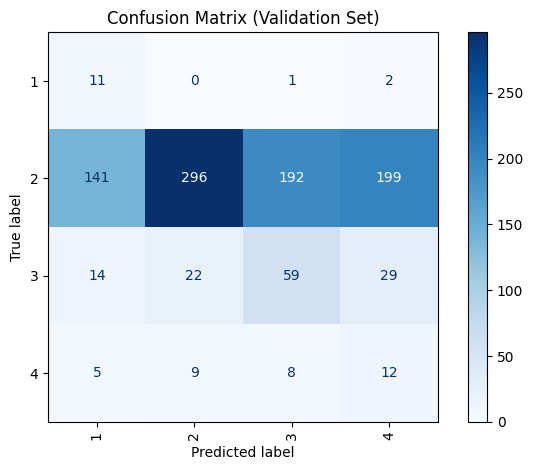

[[ 11   0   1   2]
 [141 296 192 199]
 [ 14  22  59  29]
 [  5   9   8  12]]
acc1 (Exact match accuracy): 0.3780
acc2 (One-off accuracy): 0.7700


In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_poly_model, X_validate_scaled, y_validate,
                                      cmap='Blues',
                                      display_labels=best_poly_model.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = best_poly_model.predict(X_validate_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_validate, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")

## Linear SVM with RFE (Recursive feature elimination)

In [ ]:
# SVM with RFE (Recursive Feature Elimination)
linear_svc = LinearSVC(max_iter=5000, class_weight='balanced')

rfe = RFE(estimator=linear_svc, n_features_to_select=20, step=1)

# Create pipeline
pipeline = Pipeline([
    ('feature_selection', rfe),
    ('svm', linear_svc)
])

param_grid = {
    'svm__C': [0.1, 1, 5, 10],  # Regularization parameter for LinearSVC
    'feature_selection__n_features_to_select': [15, 20, 25]  # Number of features to select using RFE
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_validate_scaled)


print("Best Linear SVM with RFE Model:", grid_search.best_params_)

Best Linear SVM with RFE Model: {'feature_selection__n_features_to_select': 20, 'svm__C': 10}


In [ ]:
# Evaluate performance on validation set
validate_accuracy_rfe = accuracy_score(y_validate, y_val_pred)
validate_report_rfe = classification_report(y_validate, y_val_pred)

# Print RFE results on validation set
print("Validation Accuracy After RFE:", validate_accuracy_rfe)
print("Classification Report After RFE (Validation Set):\n", validate_report_rfe)

# Evaluate the final model on the test set
y_test_pred_rfe = best_model.predict(X_test_scaled)

# Evaluate performance on the test set
accuracy_rfe = accuracy_score(y_test, y_test_pred_rfe)
report_rfe = classification_report(y_test, y_test_pred_rfe)

# Print final results
print("Test Accuracy After RFE and Hyperparameter Tuning:", accuracy_rfe)
print("Classification Report After RFE (Test Set):\n", report_rfe)

Validation Accuracy After RFE: 0.368
Classification Report After RFE (Validation Set):
               precision    recall  f1-score   support

           1       0.05      0.71      0.09        14
           2       0.95      0.32      0.48       828
           3       0.30      0.63      0.40       124
           4       0.05      0.38      0.09        34

    accuracy                           0.37      1000
   macro avg       0.34      0.51      0.27      1000
weighted avg       0.83      0.37      0.45      1000

Test Accuracy After RFE and Hyperparameter Tuning: 0.335
Classification Report After RFE (Test Set):
               precision    recall  f1-score   support

           1       0.01      0.50      0.03         6
           2       0.93      0.30      0.45       857
           3       0.24      0.54      0.33       119
           4       0.05      0.67      0.09        18

    accuracy                           0.34      1000
   macro avg       0.31      0.50      0.23      

<Figure size 1000x800 with 0 Axes>

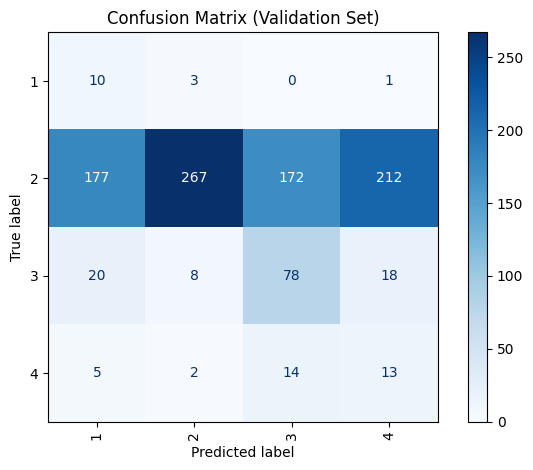

[[ 10   3   0   1]
 [177 267 172 212]
 [ 20   8  78  18]
 [  5   2  14  13]]
acc1 (Exact match accuracy): 0.3680
acc2 (One-off accuracy): 0.7600


In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_model, X_validate_scaled, y_validate,
                                      cmap='Blues',
                                      display_labels=best_model.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = best_model.predict(X_validate_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_validate, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")